In [32]:
import sympy as sp
from sympy import sin, cos, pi
from sympy.interactive import printing
import pickle
import numpy as np
import scipy as sc
import scipy.interpolate
from scipy.integrate import odeint
import matplotlib.pyplot as plt

import symbtools as st
import symbtools.modeltools as mt
import symbtools.noncommutativetools as nct

In [33]:
t = sp.Symbol('t')
Np = 2
Nq = 0
n = Np + Nq
pp = st.symb_vector("p1:{0}".format(Np+1))
qq = st.symb_vector("q1:{0}".format(Nq+1))
aa = st.symb_vector("a1:{0}".format(Nq+1))
ww = st.symb_vector("w1:{0}".format(Nq+1))

ttheta = st.row_stack(pp, qq) ##:T
tthetad = st.time_deriv(ttheta, ttheta) ##:T
tthetadd = st.time_deriv(ttheta, ttheta, order=2) ##:T
st.make_global(ttheta, tthetad)

In [34]:
params = sp.symbols('m, J, Jb, r, g')
st.make_global(params)
B = m / (Jb/r**2 + m)

tau1 = sp.Symbol("tau1")

In [52]:
#Einheitsvektoren
ex = sp.Matrix([1,0])
ey = sp.Matrix([0,1])

# p1 = r
# p2 = phi
# Koordinaten der Schwerpunkte und Gelenke
S1 = 0 # Schwerpunkt Wippe


# S2 = p1 * mt.Rz(p2) * ex
S2 = mt.Rz(p2) * sp.Matrix([p1, r])

# Zeitableitungen der Schwerpunktskoordinaten
Sd2  = st.time_deriv(S2, ttheta) ##

In [54]:
S2

Matrix([
[p1*cos(p2) - r*sin(p2)],
[p1*sin(p2) + r*cos(p2)]])

In [55]:
# Energie
T_trans = (m * Sd2.T * Sd2) / 2  # translation energy
T_rot = (J * pdot2**2 + Jb * pdot2**2 + Jb * (pdot1 / r) ** 2) / 2  # rotation energy
T = T_trans[0] + T_rot
V = m * g * S2[1]

In [57]:
L = T + V
dLdqd = sp.Derivative(L, tthetad).doit().simplify()
dLdq = sp.Derivative(L, ttheta).doit().simplify()
ddLdqddt = st.time_deriv(dLdqd, ttheta).simplify()
ddLdqddt


Matrix([
[                                                 Jb*pddot1/r**2 + m*pddot1 - m*pddot2*r],
[J*pddot2 + Jb*pddot2 + m*p1**2*pddot2 + 2*m*p1*pdot1*pdot2 - m*pddot1*r + m*pddot2*r**2]])

In [58]:
mod = mt.generate_symbolic_model(T, V, ttheta, [0, tau1])

In [59]:
mod.MM.simplify()
mod.MM

Matrix([
[Jb/r**2 + m,                      -m*r],
[       -m*r, J + Jb + m*p1**2 + m*r**2]])

In [60]:
mod.eqns

Matrix([
[                                                           Jb*pddot1/r**2 + g*m*sin(p2) - m*p1*pdot2**2 + m*pddot1 - m*pddot2*r],
[J*pddot2 + Jb*pddot2 + g*m*p1*cos(p2) - g*m*r*sin(p2) + m*p1**2*pddot2 + 2*m*p1*pdot1*pdot2 - m*pddot1*r + m*pddot2*r**2 - tau1]])

In [44]:
mod.eqns # mit hauser ansatz

Matrix([
[                           Jb*pddot1/r**2 + g*m*sin(p2) - m*p1*pdot2**2 + m*pddot1],
[J*pddot2 + Jb*pddot2 + g*m*p1*cos(p2) + m*p1**2*pddot2 + 2*m*p1*pdot1*pdot2 - tau1]])

In [61]:
mod.calc_state_eq(simplify=True)
sp.simplify(mod.state_eq)

Matrix([
[                                                                                                                                                                                      pdot1],
[                                                                                                                                                                                      pdot2],
[m*r**2*(-r*(g*m*p1*cos(p2) - g*m*r*sin(p2) + 2*m*p1*pdot1*pdot2 - tau1) + (g*sin(p2) - p1*pdot2**2)*(-J - Jb - m*p1**2 - m*r**2))/(J*Jb + Jb**2 + Jb*m*p1**2 + m*r**2*(J + 2*Jb + m*p1**2))],
[             (-m**2*r**3*(g*sin(p2) - p1*pdot2**2) + (-Jb - m*r**2)*(g*m*p1*cos(p2) - g*m*r*sin(p2) + 2*m*p1*pdot1*pdot2 - tau1))/(J*Jb + Jb**2 + Jb*m*p1**2 + m*r**2*(J + 2*Jb + m*p1**2))]])

In [62]:
# https://www.diag.uniroma1.it/~oriolo/ur/material/ReactionWheel.pdf
# for 3 states:
h = p1
h

p1

In [47]:
# for 4 states:
# h = J1*p1 + I2*p2

In [63]:
ff = mod.state_eq.subs(tau1, 0)
ff

Matrix([
[                                                                                                                                                                                                                                                                pdot1],
[                                                                                                                                                                                                                                                                pdot2],
[m*r*(-g*m*p1*cos(p2) + g*m*r*sin(p2) - 2*m*p1*pdot1*pdot2)/(J*Jb/r**2 + J*m + Jb**2/r**2 + Jb*m*p1**2/r**2 + 2*Jb*m + m**2*p1**2) + (-g*m*sin(p2) + m*p1*pdot2**2)*(J + Jb + m*p1**2 + m*r**2)/(J*Jb/r**2 + J*m + Jb**2/r**2 + Jb*m*p1**2/r**2 + 2*Jb*m + m**2*p1**2)],
[              m*r*(-g*m*sin(p2) + m*p1*pdot2**2)/(J*Jb/r**2 + J*m + Jb**2/r**2 + Jb*m*p1**2/r**2 + 2*Jb*m + m**2*p1**2) + (Jb/r**2 + m)*(-g*m*p1*cos(p2) + g*m*r*sin(p2) - 2*m*p1*pdot1*pdot2)/(J*J

In [64]:
gg = (mod.state_eq - ff).jacobian(mod.tau)
gg

Matrix([
[                                                                                   0],
[                                                                                   0],
[          m*r/(J*Jb/r**2 + J*m + Jb**2/r**2 + Jb*m*p1**2/r**2 + 2*Jb*m + m**2*p1**2)],
[(Jb/r**2 + m)/(J*Jb/r**2 + J*m + Jb**2/r**2 + Jb*m*p1**2/r**2 + 2*Jb*m + m**2*p1**2)]])

In [65]:
mod.calc_coll_part_lin_state_eq(simplify=True)

In [67]:
xx = mod.x ##:T
f = mod.ff ##:
G = mod.gg 
g1, = st.col_split(G) ##:
xx

Matrix([
[   p1],
[   p2],
[pdot1],
[pdot2]])

In [68]:
f

Matrix([
[                                          pdot1],
[                                          pdot2],
[m*r**2*(-g*sin(p2) + p1*pdot2**2)/(Jb + m*r**2)],
[                                              0]])

In [69]:
G

Matrix([
[                   0],
[                   0],
[m*r**3/(Jb + m*r**2)],
[                   1]])

In [70]:
eqp1 = sp.Matrix([0, 0, 0, 0 ])

# Probe:
f.subz(xx, eqp1) ##:T

Matrix([
[0],
[0],
[0],
[0]])

In [71]:
# Parameterwerte
parameter_values = [(g, 9.81), (m, 0.05), (r, 0.01), (J, 0.02), (Jb, 2e-6)]
replm =  parameter_values + list(zip(xx, eqp1)) ##
replm

[(g, 9.81),
 (m, 0.05),
 (r, 0.01),
 (J, 0.02),
 (Jb, 2e-06),
 (p1, 0),
 (p2, 0),
 (pdot1, 0),
 (pdot2, 0)]

In [72]:
# A1 = f.jacobian(xx).subs(replm) ##
A1 = ff.jacobian(xx).subs(replm) ##
A1

Matrix([
[                 0,                  0, 1, 0],
[                 0,                  0, 0, 1],
[-0.175148545963549,  -7.00664243272582, 0, 0],
[ -24.5207964348969, 0.0700594183854196, 0, 0]])

In [73]:
# b1 = G.subs(replm) ##
b1 = gg.subs(replm) ##
b1

Matrix([
[                0],
[                0],
[0.357081643146889],
[ 49.9914300405645]])

In [ ]:
def normalize_F(F):
    return F / F[0]

In [ ]:
def F_env_order(F):
    return [F[0,0], F[0,2], F[0,1], F[0,3]]


In [ ]:
a = 1.2
b = 3.4

poles = np.r_[-1.5+a*1j, -1.5-a*1j, -1.3 + b*1j, -1.3 - b*1j] ##:
# poles = np.linspace(-5, -8, 4)
# k1 = st.siso_place(A1, b1, poles)
# print(k1)
# A1-b1@k1
import control as ctrl
F = ctrl.place(np.array(A1, dtype=float), np.array(b1, dtype=float), poles)
print("F", F)
print("F in env order of x, xdot, phi, phidot:")
F_env = F_env_order(F)
print(F_env)
np.linalg.eigvals(np.array(A1, dtype=float) - np.array(b1, dtype=float) @ F)

F [[-0.63006441  0.49484948 -0.14085323  0.1120112 ]]
F in env order of x, xdot, phi, phidot:
[-0.6300644137614678, -0.14085322764525993, 0.49484948, 0.1120112]


array([-1.3+3.4j, -1.3-3.4j, -1.5+1.2j, -1.5-1.2j])

3 state components

LQR

In [ ]:
from scipy.linalg import solve_continuous_are
# Q = np.diag([1000, 1000, 1000, 1000])
Q = np.diag([30, 30, 30, 30])
R = 1
A = np.array(A1, dtype=float)
B = np.array(b1, dtype=float)
P = solve_continuous_are(A, B, Q, R)
# print(P)
K = 1/R * B.T @ P
print(K)
# print(normalize_F(F_LQR))
print("F in env order of x, xdot, phi, phidot:")
F_env = F_env_order(K)
print(F_env)
print(np.linalg.eigvals(np.array(A1, dtype=float) - np.array(b1, dtype=float) @ K))

[[-5.9896445  26.2098074  -8.43436161  5.57211783]]
F in env order of x, xdot, phi, phidot:
[-5.989644501647571, -8.434361610122082, 26.20980739989586, 5.572117832137562]
[-273.83207897+0.j          -1.87104003+1.8727748j   -1.87104003-1.8727748j   -1.00387477+0.j       ]


In [ ]:
np.linalg.eigvals(np.array(A1, dtype=float) - np.array(b1, dtype=float) @ K)

array([-1.72287216e+05+0.j        , -9.99999999e-01+0.j        , -8.82387022e+00+0.02868831j, -8.82387022e+00-0.02868831j])

In [ ]:
xx

Matrix([
[   p1],
[   p2],
[pdot1],
[pdot2]])

3 state

In [ ]:
from scipy.linalg import solve_continuous_are
# Q = np.diag([1000, 1000, 1000, 1000])
Q = np.diag([30, 30, 30])
R = 1
A = np.array(A3, dtype=float)
B = np.array(b3, dtype=float)

P = solve_continuous_are(A, B, Q, R)
# print(P)
K = 1/R * B.T @ P
print(K)
# print(normalize_F(F_LQR))

[[-1.48662192e+04 -1.68475490e+03 -5.47722557e+00]]


swingup

In [ ]:
kv = 0.1
ke = 1000
E0 = 1/2 * J1 * pdot2**2 + (m1*s + m2*l)*g*(1-cos(p1))
u = I2 * ke * E0 * pdot1 - kv* pdot2
u

1000*I2*pdot1*(g*(1 - cos(p1))*(l*m2 + m1*s) + pdot2**2*(0.5*I1 + 0.5*I2 + 0.5*l**2*m2 + 0.5*m1*s**2)) - 0.1*pdot2

In [ ]:
repr(u.subs(parameter_values))

'0.032*pdot1*(0.00246059*pdot2**2 - 0.3831786*cos(p1) + 0.3831786) - 0.1*pdot2'

In [ ]:
# calculate Q from given F
F_NN = np.array([[16.94674301,  31.63287544, 150.45680237,  40.50919724]])
p = [sp.var(f"p{i}") for i in range(16)]
P = sp.Matrix(np.array(p).reshape(4,4))
sol = sp.solve(b1.T@P-sp.Matrix(F_NN), P)
P_num = P.subs(sol).subs([("p2", sol[p[8]]), ("p6", sol[p[9]]), ("p14", sol[p[11]])]).subs(zip(p, sp.ones(16,1)))
# print(P_num)
assert np.sum(B.T@P_num - F_NN) == 0
Q = -(A.T@P_num + P_num@A-P_num@B@B.T@P_num)
print(Q.eigenvals())
Q = np.array(Q, dtype=float)



ShapeError: Matrix size mismatch.

In [ ]:
k1 = st.siso_place(A1, b1, poles)##:T

controller1_expr1 = k1.T*mod.xx
controller1_func_intern = st.expr_to_func(mod.xx, k1.T*mod.xx)

def controller1_func(xx, t):
    # Zeit t ignorieren
    return controller1_func_intern(*xx)

k1

Matrix([
[ 15875.5857111262],
[0.627928577300507],
[ 958.665427553576],
[0.633727212114664]])

In [ ]:
# Probe
A = A1 + b1*k1.T
A.eigenvals(rational=False)

{-1.3 - 3.4*I: 1, -1.5 - 1.2*I: 1, -1.5 + 1.2*I: 1, -1.3 + 3.4*I: 1}

In [ ]:
# Zeit-Array und Anfangswerte
tt = np.arange(0, 10, 1e-3)
xx0 = [3, 0, 0, 0] ##

#Erstellung des Simulationsmodells
sm = st.SimulationModel(mod.ff, mod.gg, mod.xx, model_parameters=parameter_values)
rhs1 = sm.create_simfunction(controller_function=controller1_func)

# Durchführung der Simulation
res = odeint(rhs1, xx0, tt)
X1, X2, X3, X4 = res.T
aa1 = controller1_func_intern(X1, X2, X3, X4)

c:\Users\Julius Fiedler\anaconda3\envs\da\lib\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


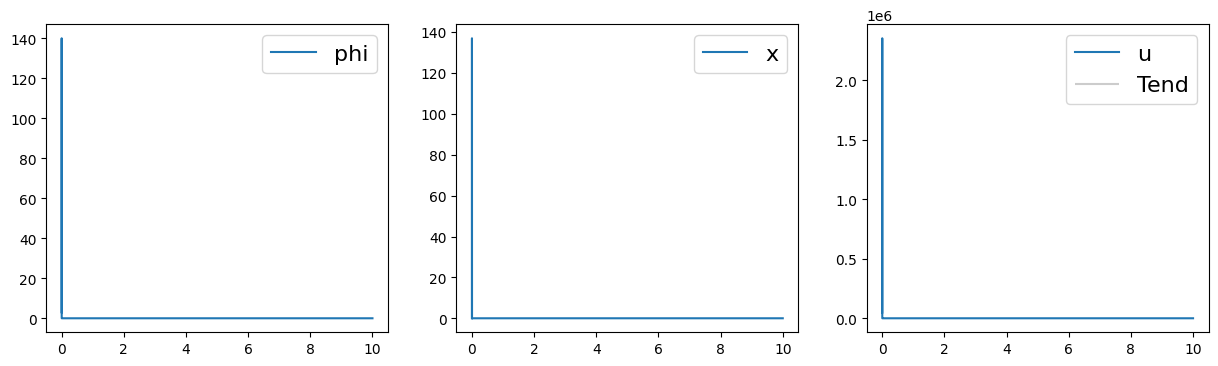

In [ ]:
T_fin = 6
plt.figure(figsize=(15,4))
plt.subplot(1, 3, 1)
plt.plot(tt, X1, label="phi")
plt.legend(loc='best', fontsize=16)
plt.subplot(1, 3, 2)
plt.plot(tt, X2, label="x")
plt.legend(loc='best', fontsize=16)
plt.subplot(1, 3, 3)
plt.plot(tt, aa1, label="u")
plt.vlines([T_fin], -20, 20, color='0.8', label=r'Tend')
plt.legend(loc='best', fontsize=16)

Simulation

In [ ]:
from scipy.integrate import solve_ivp
def rhs(t, state):
    x, x_dot, theta, theta_dot = state
    x1, x2, x3, x4 = x, theta, x_dot, theta_dot # change order
    g = 9.8
    l = 0.5
    m1 = 1.0
    m2 = 0.1
    F = np.array([[-23.42598624,  -2.49197248,  -4.05749235,  -2.51498471]])
    u1 = - F @ np.array([x1, x2, x3, x4])
    dx1_dt = x3
    dx2_dt = x4
    dx3_dt = (-g*m2*np.sin(2*x2)/2 + l*m2*theta_dot**2*np.sin(x2) + u1)/(m1 + m2*np.sin(x2)**2)
    dx4_dt = (g*(m1 + m2)*np.sin(x2) - (l*m2*theta_dot**2*np.sin(x2) + u1)*np.cos(x2))/\
        (l*(m1 + m2*np.sin(x2)**2))
    
    return [dx1_dt, dx3_dt, dx2_dt, dx4_dt] # change order back

tend = 10
tt = np.linspace(0, tend, 2000)
xx0 = [0, 0, 0.01, 0]
s = solve_ivp(rhs, (0, tend), xx0, t_eval=tt)
labels = ["x", "xdot", "phi", "phidot"]
for i in range(4):
    plt.plot(s.t, s.y[i], label=labels[i])
plt.legend()
plt.show()

KeyboardInterrupt: 